In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pyroed.datasets.data import load_tf_data
import torch

In [26]:
rand_results = []
data = load_tf_data()
cutoffs = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 
           140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
for seed in range(10000):
    ids = torch.randperm(len(data["response"]))[:250]
    responses = data['response'][ids]
    response_curve = [responses[:cutoff].max().item() for cutoff in cutoffs]
    rand_results.append(response_curve)    

In [5]:
oed_results = {}

for features in ['singleton', 'pairwise']:
    for temperature in [1.0, 4.0]:
        oed_results[(features, temperature)] = []
        for seed in range(50):
            f = "results/results.{}.s{}.temp{}.nb7.nspb10.nis30.pkl"
            f = f.format(features, seed, int(temperature))
            try:
                oed_results[(features, temperature)].append( pickle.load(open(f, 'rb')) )
            except Exception as e:
                pass
        assert len(oed_results[(features, temperature)]) == 50

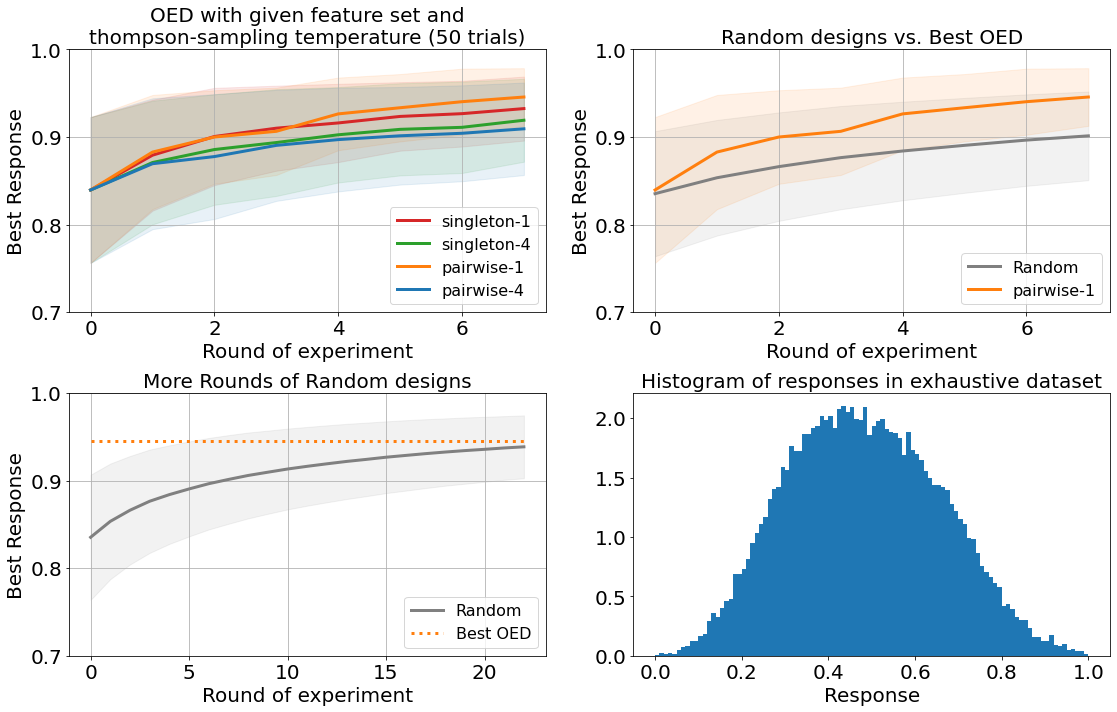

In [30]:
fig, axes = plt.subplots(2, 2, sharey=False, figsize=(16, 10))

def add_plot(features, temperature, color):
    mean = np.mean(np.stack(oed_results[(features, temperature)]), axis=0)
    std = np.std(np.stack(oed_results[(features, temperature)]), axis=0)
    axes[0][0].plot(np.arange(8), mean, color=color, lw=3.0,
                 label="{}-{}".format(features, int(temperature)))
    axes[0][0].fill_between(np.arange(8), mean + std, mean - std, color=color, alpha=0.1)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']    
    
for features in ['singleton', 'pairwise']:
    for temperature in [1.0, 4.0]:    
        add_plot(features, temperature, colors.pop())

mean = np.mean(np.stack(rand_results), axis=0)[:8]
std = np.std(np.stack(rand_results), axis=0)[:8]
axes[0][1].plot(np.arange(8), mean, color='grey', lw=3.0, label="Random")
axes[0][1].fill_between(np.arange(8), mean + std, mean - std, color='grey', alpha=0.1)        
mean = np.mean(np.stack(oed_results[('pairwise', 1.0)]), axis=0)
std = np.std(np.stack(oed_results[('pairwise', 1.0)]), axis=0)
axes[0][1].plot(np.arange(8), mean, color='tab:orange', lw=3.0, label="pairwise-1")
axes[0][1].fill_between(np.arange(8), mean + std, mean - std, color='tab:orange', alpha=0.1)

mean = np.mean(np.stack(rand_results), axis=0)
std = np.std(np.stack(rand_results), axis=0)
axes[1][0].plot(np.arange(23), mean, color='grey', lw=3.0, label="Random")
axes[1][0].fill_between(np.arange(23), mean + std, mean - std, color='grey', alpha=0.1)           
oed_best = np.mean(np.stack(oed_results[('pairwise', 1.0)]), axis=0)[-1]
axes[1][0].plot(np.arange(23), np.ones(23) * oed_best, ls='dotted',
                color='tab:orange', lw=3.0, label="Best OED")

axes[1][1].hist(data['response'].numpy(), bins=100, density=True)
axes[1][1].tick_params(axis='both', which='major', labelsize=20)
axes[1][1].set_xlabel('Response', fontsize=20)

for ax in [axes[0][0], axes[0][1], axes[1][0]]:
    ax.grid()
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0.7, 1.0)
    ax.set_xlabel('Round of experiment', fontsize=20)
    ax.set_ylabel('Best Response', fontsize=20)
    ax.legend(fontsize=16, loc='lower right')

axes[0][0].set_title("OED with given feature set and\nthompson-sampling temperature (50 trials)", fontsize=20)
axes[0][1].set_title("Random designs vs. Best OED", fontsize=20)
axes[1][0].set_title("More Rounds of Random designs", fontsize=20)
axes[1][1].set_title("Histogram of responses in exhaustive dataset", fontsize=20)

plt.tight_layout()
plt.savefig("oed_vs_rand.png")